In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [2]:
data = pd.read_csv('/content/Tmin.csv')

# Convertir la columna 'Date' al formato de fecha
data['DATE'] = pd.to_datetime(data['DATE'])

# Establecer la columna 'date' como índice
data.set_index('DATE', inplace=True)

data.head()


,TMIN
DATE,
1957-06-30,-4
1957-07-01,-3
1957-07-02,-2
1957-07-03,0
1957-07-04,0


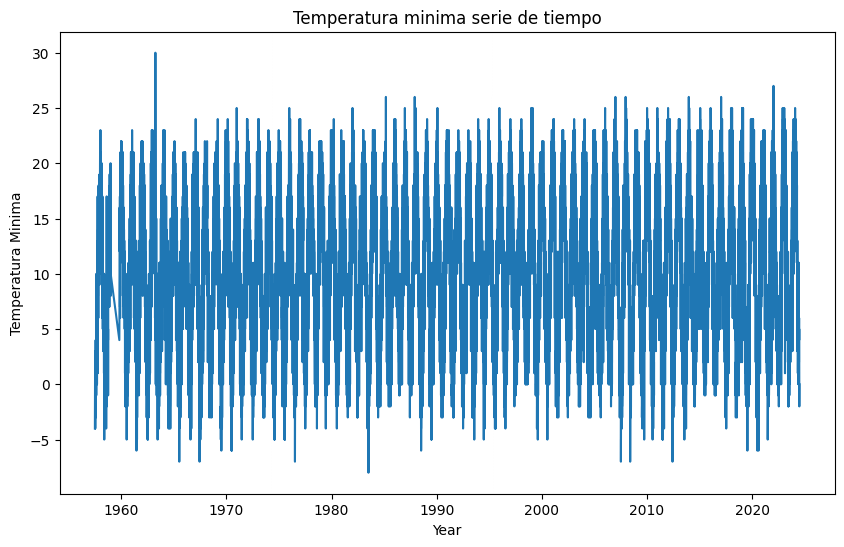

In [3]:
# Trazar los datos de la serie temporal
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title('Temperatura minima serie de tiempo')
plt.xlabel('Year')
plt.ylabel('Temperatura Minima')
plt.show()

In [4]:
# Normalizamos la data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Dividir los datos en conjuntos de train y prueba.
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # Número de pasos de tiempo para mirar atrás
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [6]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.1),
    LSTM(50, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/100
106/106 [==============================] - 13s 98ms/step - loss: 0.1380 - val_loss: 0.0699
Epoch 2/100
106/106 [==============================] - 5s 52ms/step - loss: 0.0809 - val_loss: 0.0684
Epoch 3/100
106/106 [==============================] - 7s 65ms/step - loss: 0.0783 - val_loss: 0.0698
Epoch 4/100
106/106 [==============================] - 10s 97ms/step - loss: 0.0768 - val_loss: 0.0664
Epoch 5/100
106/106 [==============================] - 6s 55ms/step - loss: 0.0756 - val_loss: 0.0660
Epoch 6/100
106/106 [==============================] - 6s 60ms/step - loss: 0.0749 - val_loss: 0.0642
Epoch 7/100
106/106 [==============================] - 6s 59ms/step - loss: 0.0725 - val_loss: 0.0634
Epoch 8/100
106/106 [==============================] - 5s 52ms/step - loss: 0.0715 - val_loss: 0.0651
Epoch 9/100
106/106 [==============================] - 7s 67ms/step - loss: 0.0705 - val_loss: 0.0652
Epoch 10/100
106/106 [==============================] - 6s 52ms/step - loss: 0.0

226/226 [==============================] - 2s 9ms/step


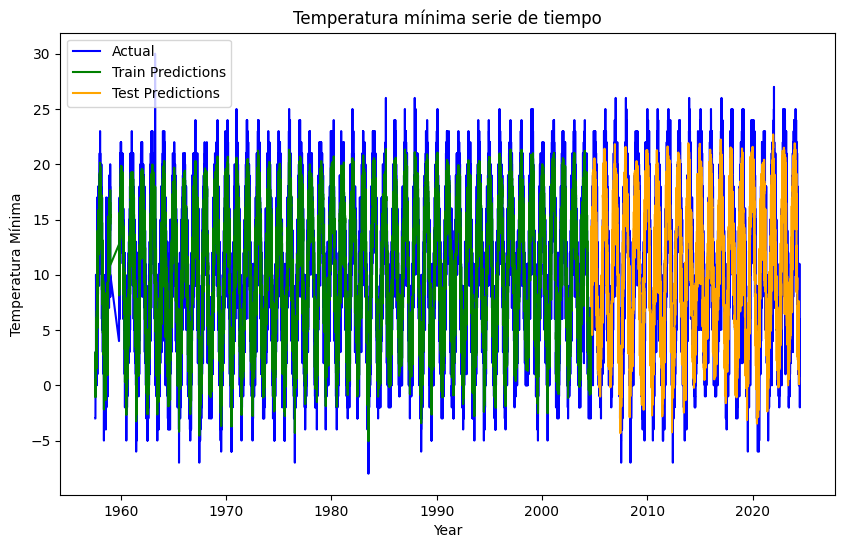

In [7]:
# Asumimos que data y scaler ya están definidos
# forecast_period = 30, last_sequence = X_test[-1], seq_length = tamaño de la secuencia usada para LSTM

# Predecir usando el modelo entrenado
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Transformación inversa de las predicciones
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Convertir índice de data a datetime si no lo está
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data.index = pd.to_datetime(data.index)

# Ajustar el índice de las predicciones
train_index = data.index[seq_length:seq_length+len(train_predictions)]
test_index = data.index[seq_length+len(train_predictions):seq_length+len(train_predictions)+len(test_predictions)]

# Plot predicciones
plt.figure(figsize=(10, 6))

# Plot data actual
plt.plot(data.index[seq_length:], data['TMIN'][seq_length:], label='Actual', color='blue')

# Plot predicciones de entramiento
plt.plot(train_index, train_predictions, label='Train Predictions', color='green')

# Plot predicciones de prueba
plt.plot(test_index, test_predictions, label='Test Predictions', color='orange')

plt.title('Temperatura mínima serie de tiempo')
plt.xlabel('Year')
plt.ylabel('Temperatura Mínima')
plt.legend()
plt.show()

1/1 [==============================] - 0s 26ms/step


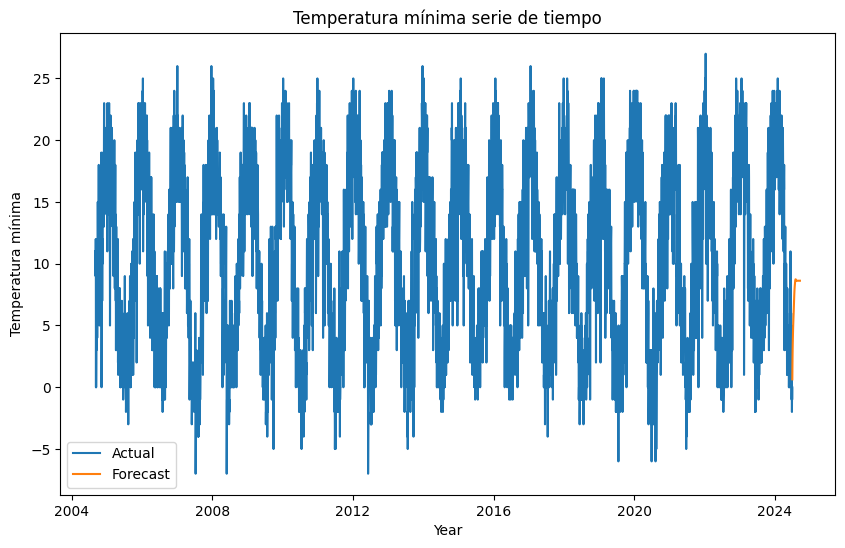

In [17]:
#Prediccion de temperatura
forecast_period = 80
forecast = []

# Utilice la última secuencia de los datos de prueba para hacer predicciones
last_sequence = X_test[-1]

for _ in range(forecast_period):
    # Remodelar la secuencia para que coincida con la forma de entrada del modelo
    current_sequence = last_sequence.reshape(1, seq_length, 1)
    # Predecir el siguiente valor
    next_prediction = model.predict(current_sequence)[0][0]
    # Agregar la predicción a la lista de pronósticos
    forecast.append(next_prediction)
    # Actualice la última secuencia eliminando el primer elemento y agregando el valor previsto
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Transformación inversa de los valores pronosticados.
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Convertir el índice de datos de prueba a fecha y hora si aún no lo está
if not pd.api.types.is_datetime64_any_dtype(data.index):
    data.index = pd.to_datetime(data.index)

# Plot de los valores pronosticados
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(test_data):], scaler.inverse_transform(test_data), label='Actual')

# Frecuencia diaria para el rango de fechas
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D')
plt.plot(forecast_dates, forecast, label='Forecast')

plt.title('Temperatura mínima serie de tiempo')
plt.xlabel('Year')
plt.ylabel('Temperatura mínima')
plt.legend()
plt.show()
plt.show()

In [9]:
#!jupyter nbconvert --to html "/content/TS_TF(1).ipynb"